# 1. Image Transforms

In [1]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

In [2]:
device = torch.device("coda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
training_dataset = datasets.MNIST(root="../data", train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root="../data", train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=True)

In [4]:
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [5]:
class DeNormalize(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [6]:
def im_convert(tensor):
#     denorm = DeNormalize(mean=(0.5,), std=(0.5,))
    transform = transforms.Compose([DeNormalize((0.5,), (0.5,)),
                                    transforms.Lambda(lambda x: x.repeat(3, 1, 1) )])

    tensor = transform(tensor.clone().detach())
    tensor = tensor.permute(1,2,0)
    image = tensor.clip(0,1)
    return image

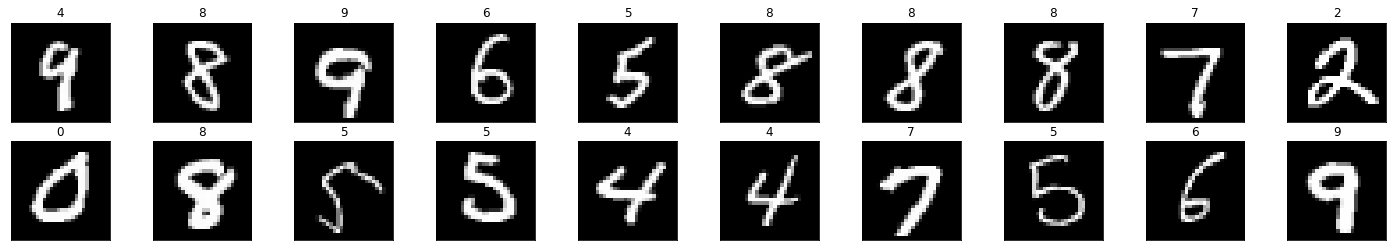

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

# 2. Neural Network Implementaion

### LeNet

![](../resources/LeNet2.png)

In [18]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500) # 4*4 = the size of feture map, 50= the number of feature maps
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50) # flatten()
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [19]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [20]:
# model.reset_parameters()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [21]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        # images shape: 1, 28, 28
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                # images shape: 1, 28, 28
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                                     
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print(f"epoch: {e+1}")
        print(f"training loss: {epoch_loss:.4f} acc: {epoch_acc.item():.4f} ")
        print(f"validation loss: {val_epoch_loss:.4f} validation acc: {val_epoch_acc.item():.4f} ")

epoch: 1
training loss: 0.5591 acc: 85.4300 
validation loss: 0.1741 validation acc: 94.9200 
epoch: 2
training loss: 0.1461 acc: 95.6533 
validation loss: 0.1018 validation acc: 96.9900 
epoch: 3
training loss: 0.0986 acc: 97.0767 
validation loss: 0.0780 validation acc: 97.5700 
epoch: 4
training loss: 0.0772 acc: 97.7000 
validation loss: 0.0628 validation acc: 98.0000 
epoch: 5
training loss: 0.0649 acc: 98.0400 
validation loss: 0.0546 validation acc: 98.3700 
epoch: 6
training loss: 0.0548 acc: 98.4050 
validation loss: 0.0471 validation acc: 98.5800 
epoch: 7
training loss: 0.0495 acc: 98.4867 
validation loss: 0.0434 validation acc: 98.5800 
epoch: 8
training loss: 0.0431 acc: 98.7050 
validation loss: 0.0413 validation acc: 98.6300 
epoch: 9
training loss: 0.0387 acc: 98.8367 
validation loss: 0.0373 validation acc: 98.7800 
epoch: 10
training loss: 0.0366 acc: 98.8567 
validation loss: 0.0333 validation acc: 98.8900 
epoch: 11
training loss: 0.0327 acc: 98.9883 
validation lo

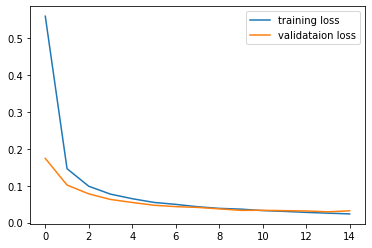

In [22]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validataion loss")
plt.legend()

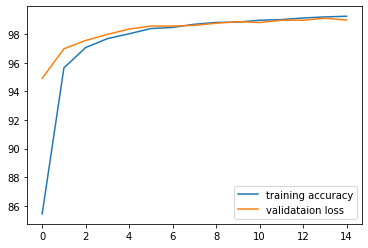

In [23]:
plt.plot(running_corrects_history, label="training accuracy")
plt.plot(val_running_corrects_history, label="validataion loss")
plt.legend()

# 3. Test Model

### Preprocess Image

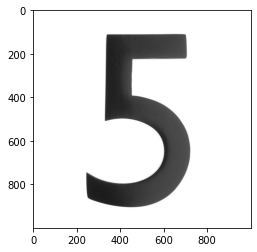

In [80]:
import requests
from PIL import Image, ImageOps
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

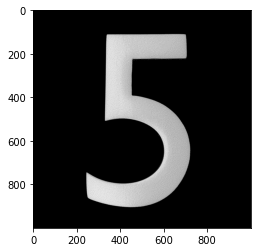

In [81]:
img = ImageOps.invert(img)
img = img.convert("1")
plt.imshow(img)

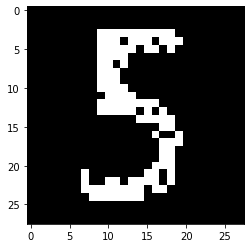

In [82]:
img = transform(img)
plt.imshow(im_convert(img))

### Predict

In [84]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


In [27]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
image = images.to(device)
labels = labels.to(device)
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(f"{preds[idx].item()} ({labels[idx].item()})", color=("green" if preds[idx]==labels[idx] else "red"))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [20, 1, 5, 5], but got 2-dimensional input of size [100, 784] instead

# Appendix

### Learning Rate = 0.01 인 경우 loss가 출렁이며 감소함

![](../resources/learning_rate.png)

- epoch이 12인 경우 정확도가 95.59

![](../resources/epoch1.png)

### Overfitted LeNet(without Dropout layer)

![](../resources/overfitted.png)